<a href="https://colab.research.google.com/github/pppyj-m/pppyj/blob/master/torch%E7%BB%83%E4%B9%A0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# torch练习

In [2]:
import torch

In [3]:
x = torch.arange(12)
x

tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11])

In [4]:
x.shape

torch.Size([12])

In [5]:
x.numel()

12

In [7]:
X = x.reshape(3,4)
X

tensor([[ 0,  1,  2,  3],
        [ 4,  5,  6,  7],
        [ 8,  9, 10, 11]])

In [8]:
torch.zeros(3,4)

tensor([[0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.]])

In [9]:
torch.ones(2,3,4)

tensor([[[1., 1., 1., 1.],
         [1., 1., 1., 1.],
         [1., 1., 1., 1.]],

        [[1., 1., 1., 1.],
         [1., 1., 1., 1.],
         [1., 1., 1., 1.]]])

In [10]:
x = torch.tensor([1.0,2,4,6])
y = torch.tensor([2,3,4,5])
x+y, x-y, x*y, x/y, x**y

(tensor([ 3.,  5.,  8., 11.]),
 tensor([-1., -1.,  0.,  1.]),
 tensor([ 2.,  6., 16., 30.]),
 tensor([0.5000, 0.6667, 1.0000, 1.2000]),
 tensor([1.0000e+00, 8.0000e+00, 2.5600e+02, 7.7760e+03]))

# 线性回归

In [ ]:
pip install d2l

In [14]:
%matplotlib inline
import random
import torch
from d2l import torch as d2l

In [15]:
#构造一个人造数据集，w=[2，-3.4], b= 4.2 和随机噪声
def synthetic_data(w,b,num_examples):
  x = torch.normal(0,1,(num_examples, len(w)))
  y = torch.matmul(x,w) + b
  y += torch.normal(0,0.01, y.shape)
  return x, y.reshape((-1,1))
true_w = torch.tensor([2,-3.4])
true_b = 4.2
features, labels = synthetic_data(true_w, true_b, 1000)


In [16]:
print("fatures:",features[0], '\nlabel',labels[0])

fatures: tensor([ 0.3055, -0.6256]) 
label tensor([6.9296])


In [ ]:
! pip install matplotlib==3.0.0

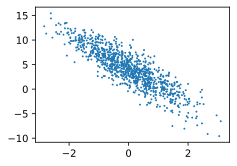

In [31]:
d2l.set_figsize()
d2l.plt.scatter(features[:,1].detach().numpy(), 
                labels.detach().numpy(), 1);

In [36]:
#定义一个data_iter函数，接收批量大小、特征矩阵和标签向量作为输入，生成大小为batch_size的小批量
def data_iter(batch_size, features, labels):
  num_examples = len(features)
  indices = list(range(num_examples))
  random.shuffle(indices)
  for i in range(0, num_examples, batch_size):
    batch_indices = torch.tensor(
        indices[i:min(i + batch_size, num_examples)]
    )
    yield features[batch_indices], labels[batch_indices]
  
batch_size = 10
for x, y in data_iter(batch_size, features, labels):
  print(x, '\n',y)
  break


tensor([[ 0.1811, -1.7787],
        [-1.0110,  1.6561],
        [-0.6087,  0.8213],
        [ 0.5708, -0.3486],
        [ 0.3055, -0.6256],
        [ 0.6084,  0.2273],
        [-0.2771,  0.3517],
        [-0.2062,  0.3947],
        [-0.9816,  0.7574],
        [ 2.2383, -0.2338]]) 
 tensor([[10.6045],
        [-3.4531],
        [ 0.2041],
        [ 6.5276],
        [ 6.9296],
        [ 4.6263],
        [ 2.4611],
        [ 2.4473],
        [-0.3489],
        [ 9.4763]])


In [52]:
w = torch.normal(0,0.01, size = (2,1), requires_grad=True)
b = torch.zeros(1, requires_grad = True)


In [38]:
def linreg(x, w, b):
  return torch.matmul(x,w)+b

In [39]:
def squared_loss(y_hat, y):
  return(y_hat - y.reshape(y_hat.shape))**2/2
  

In [40]:
def sgd(params, lr, batch_size):
  with torch.no_grad():
    for param in params:
      param -= lr*param.grad/batch_size
      param.grad.zero_()
    

In [53]:
lr = 0.03
num_epochs =10 
net = linreg
loss = squared_loss

for epoch in range(num_epochs):
  for x, y in data_iter(batch_size, features, labels):
    l = loss(net(x,w,b),y)
    l.sum().backward()
    sgd([w,b], lr, batch_size)
  with torch.no_grad():
    train_l = loss(net(features,w,b),labels)
    print(f'epoch {epoch+1}, loss{float(train_l.mean()):f}')


epoch 1, loss0.040296
epoch 2, loss0.000163
epoch 3, loss0.000054
epoch 4, loss0.000053
epoch 5, loss0.000053
epoch 6, loss0.000053
epoch 7, loss0.000053
epoch 8, loss0.000053
epoch 9, loss0.000053
epoch 10, loss0.000054


# 多层感知机

In [54]:
import torch
from torch import nn
from d2l import torch as d2l

batch_size = 256
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size)

  0%|          | 0/26421880 [00:00<?, ?it/s]

Extracting ../data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ../data/FashionMNIST/raw



  0%|          | 0/29515 [00:00<?, ?it/s]

Extracting ../data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ../data/FashionMNIST/raw



  0%|          | 0/4422102 [00:00<?, ?it/s]

Extracting ../data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ../data/FashionMNIST/raw



  0%|          | 0/5148 [00:00<?, ?it/s]

Extracting ../data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ../data/FashionMNIST/raw



/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [55]:
num_inputs, num_outputs, num_hiddens = 784, 10, 256
W1 = nn.Parameter(
    torch.randn(num_inputs, num_hiddens, requires_grad = True)
)
b1 = nn.Parameter(torch.zeros(num_hiddens, requires_grad = True))

W2 = nn.Parameter(torch.randn(num_hiddens,num_outputs, requires_grad = True))

b2 = nn.Parameter(torch.zeros(num_outputs, requires_grad=True))

params = [W1, b1, W2, b2]


In [56]:
def relu(x):
  a = torch.zeros_like(x)
  return torch.max(x,a)
  

In [59]:
def net(x):
  X = x.reshape((-1, num_inputs))
  H = relu(X @ W1 + b1)
  return (H @ W2 +b2)
loss = nn.CrossEntropyLoss(reduction = 'none')


AssertionError: ignored

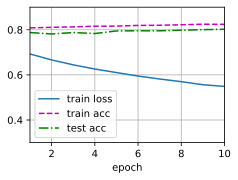

In [60]:
num_epochs, lr = 10, 0.1
updater = torch.optim.SGD(params,lr=lr)
d2l.train_ch3(net, train_iter, test_iter, loss, num_epochs,updater)

# Kaggle：预测房价

In [64]:
import hashlib
import os
import tarfile
import zipfile
import requests


DATA_HUB = dict()
DATA_URL = 'http://d2l-data.s3-accelerate.amazonaws.com/'

In [65]:
def download(name, cache_dir=os.path.join('..', 'data')):  #save
    """下载一个DATA_HUB中的文件，返回本地文件名"""
    assert name in DATA_HUB, f"{name} 不存在于 {DATA_HUB}"
    url, sha1_hash = DATA_HUB[name]
    os.makedirs(cache_dir, exist_ok=True)
    fname = os.path.join(cache_dir, url.split('/')[-1])
    if os.path.exists(fname):
        sha1 = hashlib.sha1()
        with open(fname, 'rb') as f:
            while True:
                data = f.read(1048576)
                if not data:
                    break
                sha1.update(data)
        if sha1.hexdigest() == sha1_hash:
            return fname  # 命中缓存
    print(f'正在从{url}下载{fname}...')
    r = requests.get(url, stream=True, verify=True)
    with open(fname, 'wb') as f:
        f.write(r.content)
    return fname

In [67]:
def download_extract(name, folder=None):  #save
    """下载并解压zip/tar文件"""
    fname = download(name)
    base_dir = os.path.dirname(fname)
    data_dir, ext = os.path.splitext(fname)
    if ext == '.zip':
        fp = zipfile.ZipFile(fname, 'r')
    elif ext in ('.tar', '.gz'):
        fp = tarfile.open(fname, 'r')
    else:
        assert False, '只有zip/tar文件可以被解压缩'
    fp.extractall(base_dir)
    return os.path.join(base_dir, folder) if folder else data_dir

def download_all():  #save
    """下载DATA_HUB中的所有文件"""
    for name in DATA_HUB:
        download(name)

In [69]:
!pip install mxnet
%matplotlib inline
import pandas as pd
from mxnet import autograd, gluon, init, np, npx
from mxnet.gluon import nn
from d2l import mxnet as d2l

npx.set_np()

     |████████████████████████████████| 47.3 MB 2.0 MB/s 
  Attempting uninstall: graphviz
    Found existing installation: graphviz 0.10.1
    Uninstalling graphviz-0.10.1:
      Successfully uninstalled graphviz-0.10.1


In [70]:
%matplotlib inline
import numpy as np
import pandas as pd
import torch
from torch import nn
from d2l import torch as d2l

In [72]:
DATA_HUB['kaggle_house_train'] = (  #save
    DATA_URL + 'kaggle_house_pred_train.csv',
    '585e9cc93e70b39160e7921475f9bcd7d31219ce')

DATA_HUB['kaggle_house_test'] = (  #save
    DATA_URL + 'kaggle_house_pred_test.csv',
    'fa19780a7b011d9b009e8bff8e99922a8ee2eb90')

In [73]:
train_data = pd.read_csv(download('kaggle_house_train'))
test_data = pd.read_csv(download('kaggle_house_test'))


正在从http://d2l-data.s3-accelerate.amazonaws.com/kaggle_house_pred_train.csv下载../data/kaggle_house_pred_train.csv...
正在从http://d2l-data.s3-accelerate.amazonaws.com/kaggle_house_pred_test.csv下载../data/kaggle_house_pred_test.csv...


In [74]:
print(train_data.shape)
print(test_data.shape)

(1460, 81)
(1459, 80)


In [75]:
print(train_data.iloc[0:4, [0, 1, 2, 3, -3, -2, -1]])


   Id  MSSubClass MSZoning  LotFrontage SaleType SaleCondition  SalePrice
0   1          60       RL         65.0       WD        Normal     208500
1   2          20       RL         80.0       WD        Normal     181500
2   3          60       RL         68.0       WD        Normal     223500
3   4          70       RL         60.0       WD       Abnorml     140000


In [76]:
all_features = pd.concat((train_data.iloc[:, 1:-1], test_data.iloc[:, 1:]))
